In [222]:
#using these guides
#https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346
#https://github.com/dataman-git/codes_for_articles/blob/master/From%20regression%20to%20RNN.ipynb
#https://datascience.stackexchange.com/questions/93180/trying-to-extend-this-code-to-include-additional-feature-volume-in-addition-to
#https://datascience.stackexchange.com/questions/91147/problems-to-understand-how-to-create-the-input-data-for-time-series-forecasting/92395?noredirect=1#comment97317_92395
#https://towardsdatascience.com/recurrent-neural-networks-for-electricity-price-prediction-a26f8411ea44
#https://github.com/Carterbouley/ElectricityPricePrediction
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [223]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [224]:
import pandas as pd
import yfinance as yf
import numpy as np
import sklearn
from yahoofinancials import YahooFinancials
AMZN = yf.download('GOLD', 
                      start='2013-01-01', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Volume']].round(2)
#all_data = AMZN[['Adj Close']].round(2)
all_data.head(10)

,Adj Close,Volume
Date,,
2013-01-02,257.31,3271000
2013-01-03,258.48,2750900
2013-01-04,259.15,1874200
2013-01-07,268.46,4910000
2013-01-08,266.38,3010700
2013-01-09,266.35,2265600
2013-01-10,265.34,2863400
2013-01-11,267.94,2413300
2013-01-14,272.73,4275000


In [225]:
len(all_data)
#len(all_data.columns)


1761

In [298]:
n_steps = 20
n_ahead = 1
epochs_ = 100

import tensorflow as tf

from tensorflow import keras
from matplotlib import pyplot as plt

# Read the data for the parameters from a csv file
import urllib.request
#Delete the first column as it is not used in the tutorial for forecasting


training = ((len(all_data)-n_steps-n_ahead)*.714)
validation = ((len(all_data)-n_steps-n_ahead)*.856)

#can handle both features!
#from sklearn.preprocessing import MinMaxScaler
#sc1 = MinMaxScaler(feature_range=(0,1))
#from sklearn.preprocessing import RobustScaler
#sc1 = RobustScaler().fit(all_data.iloc[:, 0:][0:int(validation)])

from sklearn.preprocessing import StandardScaler
sc1 = StandardScaler().fit(all_data.iloc[:, 0:][0:int(validation)])
ts_train_scaled_1 = sc1.fit_transform(all_data.iloc[:, 0:][0:int(validation)])
ts_test_scaled_1 = sc1.transform(all_data.iloc[:, 0:][int(validation):])

#data = all_data.values
#ts_train_scaled_1 = sc1.fit_transform(all_data.iloc[:, 1][0:int(training)])
#data = np.concatenate((ts_train_scaled_1, all_data[int(validation):].values), axis=0)
data = np.concatenate((ts_train_scaled_1, ts_test_scaled_1), axis=0)

series_reshaped =  np.array([data[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])
#series_reshaped2 =  np.array([all_data.values[i:i + (n_steps+n_ahead)].copy() for i in range(len(all_data.values) - (n_steps+n_ahead))])

X_train = series_reshaped[:int(training), :n_steps] 
X_valid = series_reshaped[int(training):int(validation), :n_steps] 
X_test = series_reshaped[int(validation):, :n_steps] 

#assumes first column?
#based on https://raw.githubusercontent.com/Carterbouley/ElectricityPricePrediction/master/re_fixed_multivariate_timeseires.csv
#price is 1st column
Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
for step_ahead in range(1, n_ahead + 1):     
   Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:int(training)] 
Y_valid = Y[int(training):int(validation)] 
Y_test = Y[int(validation):]


In [293]:

np.random.seed(42)
tf.random.set_seed(42)

from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

model6 = keras.models.Sequential([
    
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_percentage_error'])
history = model6.fit(X_train, Y_train, epochs=epochs_,batch_size=64,
                    validation_data=(X_valid, Y_valid))



Epoch 1/100
20/20 [==============================] - 2s 21ms/step - loss: 0.4369 - mean_absolute_percentage_error: 139.9424 - val_loss: 1.2763 - val_mean_absolute_percentage_error: 53.8229
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0456 - mean_absolute_percentage_error: 65.4504 - val_loss: 0.8742 - val_mean_absolute_percentage_error: 43.8384
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0197 - mean_absolute_percentage_error: 50.3362 - val_loss: 0.8147 - val_mean_absolute_percentage_error: 42.3397
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0108 - mean_absolute_percentage_error: 34.1454 - val_loss: 0.7146 - val_mean_absolute_percentage_error: 39.1455
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0077 - mean_absolute_percentage_error: 27.3458 - val_loss: 0.6535 - val_mean_absolute_percentage_error: 37.1608
Epoch 6/100
20/20 [==============================] - 0s 4ms/ste

RobustScaler()

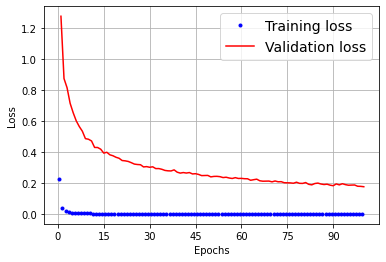

In [294]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [248]:
# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


In [295]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    
actual = pd.DataFrame((sc1.inverse_transform(X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc1,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100


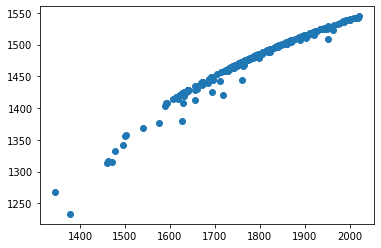

In [296]:
import matplotlib.pyplot as plt
plt.scatter(actual["actual"],actual["predictions"])

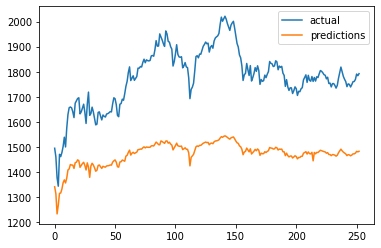

In [297]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()

In [289]:

np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, len(all_data.columns)], activation='tanh'),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

#model8.compile(loss="mape", optimizer="adam")
model8.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss='mean_squared_error')
history = model8.fit(X_train, Y_train, epochs=epochs_,batch_size=64,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
14/14 [==============================] - 5s 247ms/step - loss: 1.3978 - val_loss: 4.1894
Epoch 2/20
14/14 [==============================] - 3s 219ms/step - loss: 0.1769 - val_loss: 1.9555
Epoch 3/20
14/14 [==============================] - 3s 219ms/step - loss: 0.0685 - val_loss: 1.2354
Epoch 4/20
14/14 [==============================] - 3s 229ms/step - loss: 0.0234 - val_loss: 0.6389
Epoch 5/20
14/14 [==============================] - 3s 224ms/step - loss: 0.0148 - val_loss: 0.4049
Epoch 6/20
14/14 [==============================] - 3s 219ms/step - loss: 0.0102 - val_loss: 0.3205
Epoch 7/20
14/14 [==============================] - 3s 221ms/step - loss: 0.0091 - val_loss: 0.2736
Epoch 8/20
14/14 [==============================] - 3s 221ms/step - loss: 0.0078 - val_loss: 0.2403
Epoch 9/20
14/14 [==============================] - 3s 222ms/step - loss: 0.0071 - val_loss: 0.2144
Epoch 10/20
14/14 [==============================] - 3s 229ms/step - loss: 0.0069 - val_loss: 0.1953

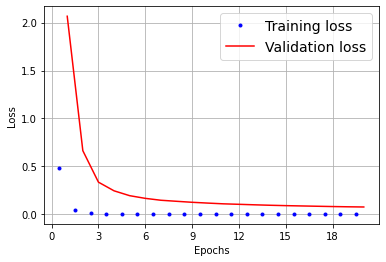

In [286]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [287]:
Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    

actual = pd.DataFrame((sc1.inverse_transform(X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc1,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

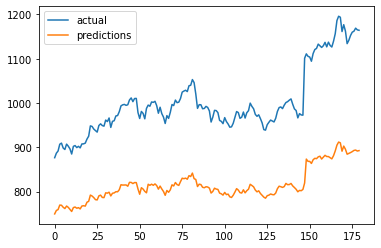

In [290]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()

In [267]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss')

np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(n_steps,len(all_data.columns))),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model9.compile(loss="mape", optimizer="adam")
history9 = model9.fit(X_train, Y_train, epochs=epochs_,batch_size=64,
                    validation_data=(X_valid, Y_valid))#, callbacks = [es] )

Epoch 1/20
28/28 [==============================] - 19s 531ms/step - loss: 57.5803 - val_loss: 25.3882
Epoch 2/20
28/28 [==============================] - 14s 495ms/step - loss: 22.1392 - val_loss: 17.1959
Epoch 3/20
28/28 [==============================] - 14s 489ms/step - loss: 18.0879 - val_loss: 12.9404
Epoch 4/20
28/28 [==============================] - 14s 492ms/step - loss: 16.4244 - val_loss: 10.5463
Epoch 5/20
28/28 [==============================] - 14s 492ms/step - loss: 15.0938 - val_loss: 8.9662
Epoch 6/20
28/28 [==============================] - 14s 506ms/step - loss: 14.0691 - val_loss: 8.9841
Epoch 7/20
28/28 [==============================] - 14s 499ms/step - loss: 13.7221 - val_loss: 8.3819
Epoch 8/20
28/28 [==============================] - 14s 494ms/step - loss: 12.7263 - val_loss: 8.2680
Epoch 9/20
28/28 [==============================] - 14s 495ms/step - loss: 12.7069 - val_loss: 8.1924
Epoch 10/20
28/28 [==============================] - 14s 494ms/step - loss: 12

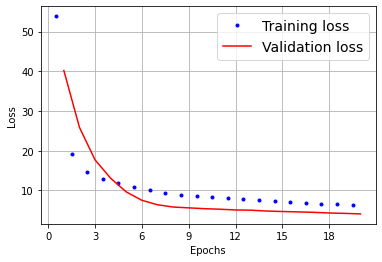

In [269]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [271]:
Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    

actual = pd.DataFrame((sc1.inverse_transform(X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc1,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

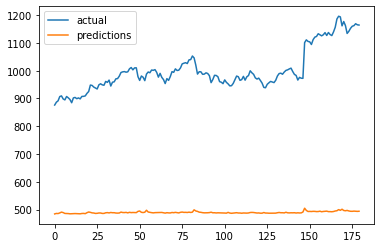

In [272]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()

In [273]:
Y_train[:, 3::2]

array([[[-1.07999637],
        [-1.08542191],
        [-1.04686928],
        ...,
        [-0.90220561],
        [-0.94941824],
        [-0.93971487]],

       [[-1.08015287],
        [-1.07185806],
        [-1.05119927],
        ...,
        [-0.92062114],
        [-0.93204608],
        [-0.97268546]],

       [[-1.08542191],
        [-1.04686928],
        [-1.06669336],
        ...,
        [-0.94941824],
        [-0.93971487],
        [-0.95291354]],

       ...,

       [[ 1.39055439],
        [ 1.41392594],
        [ 1.38878065],
        ...,
        [ 6.98835487],
        [ 6.93112586],
        [ 7.25253691]],

       [[ 1.4206557 ],
        [ 1.41616919],
        [ 1.36780886],
        ...,
        [ 6.99216318],
        [ 7.07323326],
        [ 6.96242705]],

       [[ 1.41392594],
        [ 1.38878065],
        [ 1.37344307],
        ...,
        [ 6.93112586],
        [ 7.25253691],
        [ 7.01078739]]])

In [299]:
np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, len(all_data.columns)]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model10.compile(loss="mape", optimizer="adam")
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=64,
                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])

Epoch 1/100
20/20 [==============================] - 3s 38ms/step - loss: 126.8272 - val_loss: 42.8453
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 70.4002 - val_loss: 39.8783
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 50.3387 - val_loss: 40.8896
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 34.0822 - val_loss: 38.7407
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 30.9064 - val_loss: 41.3231
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 25.6176 - val_loss: 41.8810
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 33.1127 - val_loss: 43.8660
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 37.0875 - val_loss: 44.0060
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 26.5110 - val_loss: 40.6430
Epoch 10/100
20/20 [==============================] - 0s 10ms/step - loss: 21.395

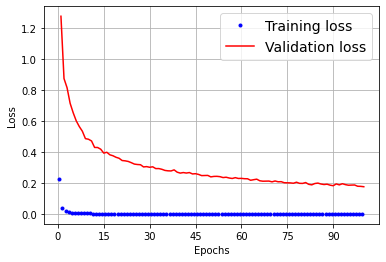

In [300]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

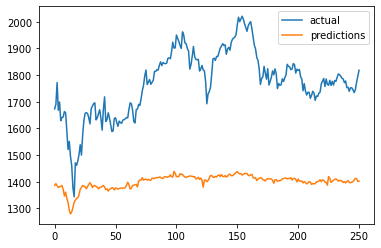

In [301]:
Y_pred = model10.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    

actual = pd.DataFrame((sc1.inverse_transform(X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc1,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()